# Импорт библиотек

In [65]:
import pandas as pd
import numpy as np

from IPython.display import Image

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, log_loss, auc, classification_report, confusion_matrix, \
    precision_recall_curve, roc_curve, confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings

warnings.filterwarnings("ignore")
RAND=10
N_FOLD=5
percent_of_negative_class = 0.958

# Метод для подсчёта метрик

In [47]:
def get_metrics(y_test, y_pred, y_score, name):
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    df_metrics['ROC_AUC'] = [roc_auc_score(y_test, y_score[:,1])]
    df_metrics['Precision'] = [precision_score(y_test, y_pred)]
    df_metrics['Recall'] = [recall_score(y_test, y_pred)]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    df_metrics['Logloss'] = [log_loss(y_test, y_score)]
    
    return df_metrics

# Подготовка данных к обучению

Выгрузим данные

In [48]:
df = pd.read_pickle('data.pickle')
df.head()

,SEMESTER,DISC_ID,TYPE_NAME,DEBT,GENDER,CITIZENSHIP,EXAM_TYPE,EXAM_SUBJECT_1,EXAM_SUBJECT_2,EXAM_SUBJECT_3,ADMITTED_EXAM_1,ADMITTED_EXAM_2,ADMITTED_EXAM_3,ADMITTED_SUBJECT_PRIZE_LEVEL,REGION_ID,mean_score
0,1,10502311854018326223,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082,82.666667
1,1,1601392918367593206,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082,82.666667
2,1,9559803959325174929,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082,82.666667
3,1,8955667882044263414,Зачет,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082,82.666667
4,1,17741967398854095262,Экзамен,0,М,15601729049989747827,ЕГЭ,70786669040476600,5533732657842394915,8388269026169219461,78.0,79.0,91.0,ЕГЭ,7805492244297918082,82.666667


Проведём разбиение на train и test

In [49]:
feature_cols = df.drop(columns = ['DEBT'])

X_train, X_test, y_train, y_test = train_test_split(feature_cols,
                                                    df['DEBT'],
                                                    test_size=0.33,
                                                    random_state=10)

# Выбор алгоритмов для стекинга

Алгоритм стекинга состоит в том, чтобы разбить выборку на несколько фолдов и итерационно получить предсказания нескольких алгоритмов на каждом фолде, обучась на всех остальных. А затем использовать предсказания каждого алгоритма как признак, формируя новый датафрейм, на котором обучится ещё один алгортим (как правило, очень простой)

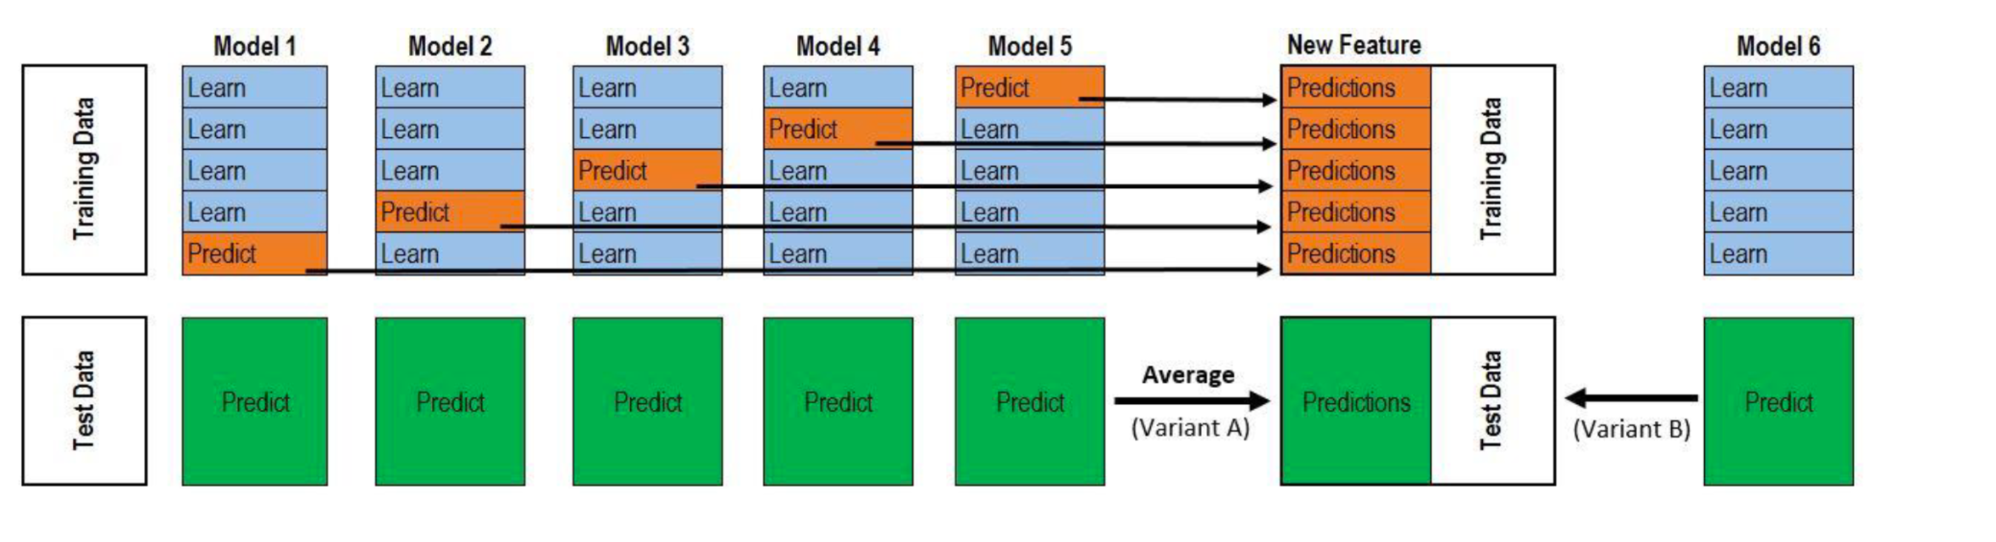

In [63]:
Image("algo.png")

Основной предшественник стекинга - войтинг, когда мы собираем голоса нескольких алгоритмов, а финальный алгоритм их усредняет. Здесь же мы делаем это много раз, обучаясь на немного отличающихся данных, а последний алгоритм просто находит в голосах закономерность. Так, если все 10 алгоритмов регулярно дают нулевую метку определённым объектам класса 1, не вписывающихся в общую закономерность, то мета-алгоритм с высокой вероятностью это найдёт и будет предсказывать для них класс 1, несмотря на то, что ни один алгоритм с этим не согласен. Мне кажется, это очень красивая идея

Ключевая цель этого ноутбука - улучшить с помощью стекинга roc_auc, полученный обученной моделью CatBoost. Практика показывает, что объединение разнородных алгоритмов даёт наилучшие результаты, поэтому в идеале они должны принадлежать разным моделям, либо иметь разные гиперпараметры, либо получать данные в разной форме на вход.

Исходя из этих соображений, я предлагаю взять
- бейзлайн Catboost 
- обученный LightGBM
- логистическую регрессию в качестве мета-алгоритма

Можно придумывать и пробовать другие вариации, остановимся пока на этом

# Реализация стекинга

## Catboost

In [51]:
cat_features = ['DISC_ID', 'TYPE_NAME', 'GENDER', 'CITIZENSHIP', 
            'EXAM_TYPE', 'EXAM_SUBJECT_1', 'EXAM_SUBJECT_2', 
            'EXAM_SUBJECT_3', 'ADMITTED_SUBJECT_PRIZE_LEVEL', 'REGION_ID']

clf = CatBoostClassifier(random_state=RAND,\
                         eval_metric="AUC", 
                         scale_pos_weight = percent_of_negative_class,
                         cat_features = cat_features)

При помощи Stratified k-fold разобьём всю обучающую выборку на фолды, и каждый раз будем делать предсказание на одном фолде, а для обучения использовать всё остальное. В конце объединим предикты на всех фолдах - это будет первый столбец в датафрейме, на котором в конце обучится мета алгоритм. Также будем выводить score на каждом фолде, потому что можем:)

In [52]:
meta_X = pd.DataFrame()

pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=N_FOLD)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(random_state=RAND,\
                         eval_metric="AUC", 
                         scale_pos_weight = percent_of_negative_class,
                         cat_features = cat_features)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model.predict(X_val)
    y_score_val = model.predict_proba(X_val)

    print("Fold:", fold + 1,
          "ROC-AUC SCORE %.3f" % roc_auc_score(y_val, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

Fold: 1 ROC-AUC SCORE 0.876
---
Fold: 2 ROC-AUC SCORE 0.888
---
Fold: 3 ROC-AUC SCORE 0.871
---
Fold: 4 ROC-AUC SCORE 0.890
---
Fold: 5 ROC-AUC SCORE 0.875
---


In [53]:
meta_X['catboost'] = np.concatenate(pred_score_val)[:,1]
meta_X.head()

,catboost
0,0.016545
1,0.007156
2,0.048764
3,0.735157
4,0.028130


# LightGBM

Проделаем те же самые шаги для LightGBM, но для него уже возьмём подобранные гиперпараметры

In [54]:
pred_val = []
pred_score_val = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model_2 = LGBMClassifier(n_estimators=7329,
                               learning_rate=0.17,
                               random_state=10,
                               scale_pos_weight=percent_of_negative_class,
                               num_leaves=1480,
                               max_depth=10,
                               min_data_in_leaf=6735,
                               lambda_l1=16,
                               lambda_l2=97,
                               bagging_fraction=0.6322273209124994)
    model_2.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=0)

    y_pred_val = model_2.predict(X_val)
    y_score_val = model_2.predict_proba(X_val)

    print("Fold:", fold + 1,
          "ROC-AUC SCORE %.3f" % roc_auc_score(y_val, y_score_val[:, 1]))
    print("---")

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

meta_X['lightGBM'] = np.concatenate(pred_score_val)[:,1]
meta_X.head()

[LightGBM] [Warning] min_data_in_leaf is set=6735, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6735
[LightGBM] [Warning] bagging_fraction is set=0.6322273209124994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6322273209124994
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] lambda_l2 is set=97, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97
Fold: 1 ROC-AUC SCORE 0.828
---
[LightGBM] [Warning] min_data_in_leaf is set=6735, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6735
[LightGBM] [Warning] bagging_fraction is set=0.6322273209124994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6322273209124994
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] lambda_l2 is set=97, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97
Fold: 2 ROC-AUC 

,catboost,lightGBM
0,0.016545,0.015100
1,0.007156,0.027427
2,0.048764,0.037937
3,0.735157,0.586223
4,0.028130,0.103077


## Logistic regression

Обучим логистическую регрессию на полученном датафрейме

In [56]:
final_clf = LogisticRegression(random_state=RAND)
final_clf.fit(meta_X, y_train)

LogisticRegression(random_state=10)

Для того, чтобы сделать предсказание мета-алгоритма на test, нам нужно сначала получить предсказания базовых алгоритмов. Сделаем это и, аналогично, объединим их в один датафрейм

In [57]:
meta_X_test = pd.DataFrame()
meta_X_test['catboost'] = model.predict_proba(X_test)[:,1]
meta_X_test['lightGBM'] = model_2.predict_proba(X_test)[:,1]
meta_X_test.head()

,catboost,lightGBM
0,0.014295,0.020963
1,0.018956,0.010604
2,0.013828,0.007080
3,0.009816,0.008622
4,0.034153,0.042326


Сделаем финальное предсказание на тестовой выборке

In [58]:
y_pred_final = final_clf.predict(meta_X_test)
y_proba_final = final_clf.predict_proba(meta_X_test)

In [59]:
get_metrics(y_test,
            y_pred_final,
            y_proba_final,
            name='StackingClassifier')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,StackingClassifier,0.960432,0.87597,0.729253,0.25306,0.375735,0.140761


Для полноты картины сделаем предсказание и на обучающей выборке

In [61]:
meta_X_train = pd.DataFrame()
meta_X_train['catboost'] = model.predict_proba(X_train)[:,1]
meta_X_train['lightGBM'] = model_2.predict_proba(X_train)[:,1]

y_pred_final = final_clf.predict(meta_X_train)
y_proba_final = final_clf.predict_proba(meta_X_train)

get_metrics(y_train,
            y_pred_final,
            y_proba_final,
            name='StackingClassifier')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,StackingClassifier,0.964042,0.90781,0.817056,0.313016,0.452629,0.125627


Скор немного упал по-сравнению с Catboost, поэтому имеет смысл опробовать другие вариации